In [1]:
%matplotlib inline

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

import pandas as pd
from Utils import *

from algorithms import *
from new_utils import *

# Comparison of algorithms for ordinal embedding

In [2]:
#Create data
dimensions= 15
number_of_points= 100

X = np.random.random((number_of_points, dimensions))
X = center_data(X)

In [3]:
n,d = X.shape
pulls = 1000
triplets, error = getTriplets(X, pulls)
    
print(ste_loss(X, triplets,1))

{'empirical_loss': 0.0, 'log_loss': 0.3992177892340308}


# Algorithms

In [4]:
# from projected_gradient import *

# M, loss, proj_grad_loss_arr = computeEmbedding(M0,
#                 n,
#                  d,
#                  triplets,
#                  num_random_restarts=0,
#                  max_iter_GD=500,
#                  max_norm=1,
#                  epsilon=0.0001,
#                  accuracy=accuracy, 
#                  verbose=False)



In [5]:
# from crowd_kernel import *

In [6]:
# X, emp_loss_train, projection_free_loss_arr = computeEmbedding(n,d,triplets,alpha=1,
#                                     num_random_restarts=0,
#                                     epsilon=0.0001,
#                                     accuracy = accuracy,
#                                     max_iters=100,
#                                     verbose=False)


In [7]:
X0 = np.random.random((n,d))
# X0 = X
stats1= triplet_algorithms(ste_loss, 
                   triplets,
                   X0,                       
                   d,
                   'full_grad', 
                   10,
                   iters=100,
                   epsilon = 0.01,
                   proj=None)

0.497
Accuracy reached in 28 iterations


In [ ]:
X0 = np.random.random((n,d))
# X0 = X
stats4= triplet_algorithms(ste_loss, 
                   triplets,
                   X0,                       
                   d,
                   'sgd', 
                   0.1,
                   iters=5000,
                   epsilon = 0.01,
                       proj=None,
                          debug=False)

0.481


In [14]:
M0 = np.random.randn(n,n)
# M0 = (M+M.transpose())/2
# M0 = M - 1.0/n*dot(ones((n,n)),M)
# print(M0)
print(ste_loss_convex(M0, triplets, 1))



{'empirical_loss': 0.525, 'log_loss': 1.4662828140516024}


In [15]:
stats2 = triplet_algorithms(ste_loss_convex, 
                   triplets,
                   M0,                       
                   d,                            
                   'full_grad', 
                    10,
                   iters=5000,
                   epsilon =0.01,
                   proj=projected)

0.525
Accuracy reached in 794 iterations


In [17]:
stats3 = triplet_algorithms(ste_loss_convex, 
                            triplets,
                            M0,                       
                            d,                            
                            'sgd', 
                            3,
                            iters=5000,
                            epsilon = 0.01,
                            proj=projected)

0.525


In [27]:
# stats2['emp']

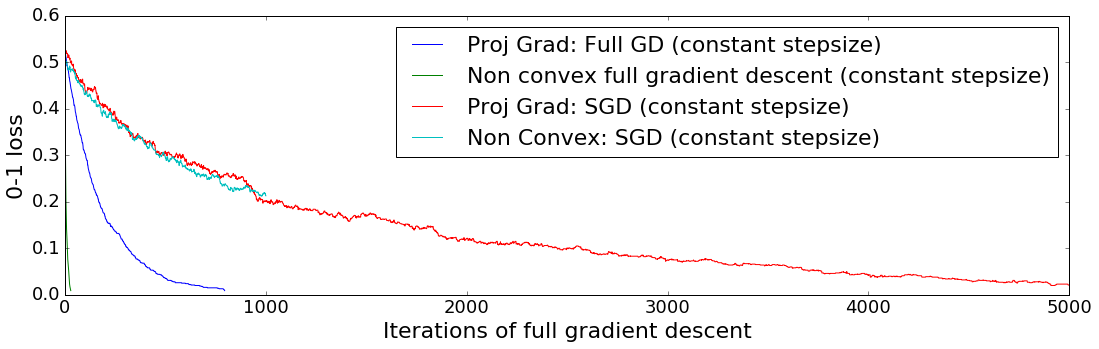

In [18]:
df = pd.DataFrame([stats2['emp'],
                   stats1['emp'],
                   stats3['emp'],
                   stats4['emp'],                   
                  ]
                 ).T
df.columns = ['Proj Grad: Full GD (constant stepsize)',
              'Non convex full gradient descent (constant stepsize)', 
              'Proj Grad: SGD (constant stepsize)',
              'Non Convex: SGD (constant stepsize)',              
             ]

ax = df.plot(figsize=(18,5), fontsize=18)
ax.set_ylabel('0-1 loss', fontsize=22)
ax.set_xlabel('Iterations of full gradient descent', fontsize=22)
ax.legend(fontsize=22);

In [ ]:
# SGD
# SVRG
# Franke Wolfe

stats['time_per_iter'];

In [ ]:
choice = '2'

In [ ]:
number_of_points= 100

X = random((number_of_points, dimensions))
X = center_data(X)
n,d = X.shape
pulls = 1000
triplets, error = getTriplets(X, pulls)

if choice == '1':
    X0 = random((n,d))
    # X0 = X
    stats = triplet_algorithms(ste_loss,
                               triplets,
                               X0,
                               d,
                               'full_grad',
                               10,
                               iters=500,
                               epsilon = 0.001,
                               proj=None)

if choice == '2':
    M0 = randn(n,n)
    stats1 = triplet_algorithms(ste_loss_convex, 
                                triplets,
                                M0,                       
                                d,                            
                                'full_grad', 
                                30,
                                iters=5000,
                                epsilon = 0.01,
                                proj=projected)

    print()

    stats2 = triplet_algorithms(ste_loss_convex, 
                                triplets,
                                M0,                       
                                d,                            
                                'sgd', 
                                3,
                                iters=5000,
                                epsilon = 0.01,
                                proj=projected)


if choice == 'all':
    X0 = random((n,d))
    # X0 = X
    print(ste_loss(X0, triplets, 1))
    stats = triplet_algorithms(ste_loss,
                               triplets,
                               X0,
                               d,
                               'full_grad',
                               10,
                               iters=500,
                               epsilon = 0.001,
                               proj=None)

    print()

    M0 = randn(n,n)
    stats2 = triplet_algorithms(ste_loss_convex, 
                                triplets,
                                M0,                       
                                d,                            
                                'full_grad', 
                                0,
                                iters=500,
                                epsilon = 0.01,
                                proj=projected)

In [ ]:
sta